# Data Integration (JSON, XML, CSV, TXT, XLSX)

#### Student Name: Reynaldo Bonita, Jr. 
#### Student ID: 29999804

Date: 26 Oct. 2018
Environment: Python 2.7.11 and Jupyter notebook
Libraries used:
* pandas - Used for handling data frames
* numpy - For computing descriptive statistics (mean, max, min)
* matplotlib - Plotted the frequency distributions
* math - For cos, sin and other 
* sklearn.linear_model - For Linear Regression
* shapefile - For reading the shape representation of Victorian subrbs
* rtree - Used to optimize algorithm for checking point in polygon using minimum bounding boxes
* shapely - Used to implement point in polygon checking algorithm
* sklearn - For Linear Regression and Z-Score Normalization

# Introduction

Integrating data from various data sources and with various data formats is the main objective of this project. The data set includes property listings and the integration involves determining the proximity of the property to major establishments and the accessibility of the city through public transport.  

Once data was integrated, the distribution of prices were analyzed and transformed in preparation for further statistical processing. To achieve this, various techniques were employed including parsing data from different formats like JSON, XML, HTML and CSV. The standardization and transformation methods used on the property price included log, power, square root, and min-max nomralizations. 

# Outline

1. Task 1: Data Integration

    1.1 Loading Files into Data Frames
    
    1.2 Identifying the Nearest Establishments
    
    1.3 Determining the Suburb of the Real Estate Property
    
    1.4 Computing the Travel Time to the CBD 


2. Task 2: Data Reshaping

    2.1 Z-Scale and Minmax Normalization 
    
    2.3 Log, power and Squareroot Transformation


3. Exportation


4. Conclusion

# Importing Libraries

In [1]:
import pandas as pd
import numpy as np
import math
import json
import datetime as dt
from bs4 import BeautifulSoup

## For processing the suburb shapefiles
import shapefile

## Needed to run the ff in a terminal to install rtree (Source: http://toblerity.org/rtree/class.html)
# pip install Rtree
# brew install spatialindex
from rtree import index

## Run 'pip install shapely' to install
from shapely.geometry import Point,polygon,shape

import matplotlib.pyplot as plt

from sklearn import linear_model

# For Z-Score Normalization
from sklearn import preprocessing

# Task 1: Data Integration

## Loading files as Data Frames

The following data sets were loaded as data frames:
- Real Estate (XML) and Real Estate (JSON) - rows with missing (ie. 'nan') values and duplicated rows were removed. 
- Shopping Centers (JSON)
- Supermarkets (HTML)
- Trains (CSV)

The real estate listing are stored in an XML file and as a JSON file. The listings were merged as one data frame by combing the records and removing duplicated rows and rows with missing values. Rows with missing values were removed because it was found that all the attributes of these rows are nulls. There was no way of imputing the missing values. Duplicated rows were removed because they are exact duplicates for all attributes. 

### Real Estate (JSON)

In [1097]:
realestate_json = pd.read_json ("real_state.json")
realestate_json.info()
realestate_json.describe()
realestate_json.head()
realestate_json ['index'] = realestate_json.apply(lambda row: "n" + str('{:.0f}'.format(row['property_id'])),axis=1)
realestate_json = realestate_json.set_index('index')
realestate_json.describe()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1010 entries, 0 to 1009
Data columns (total 10 columns):
addr_street      1001 non-null object
bathrooms        1001 non-null float64
bedrooms         1001 non-null float64
lat              1001 non-null float64
lng              1001 non-null float64
parking_space    1001 non-null float64
price            1001 non-null float64
property_id      1001 non-null float64
property_type    1001 non-null object
year             1001 non-null float64
dtypes: float64(8), object(2)
memory usage: 79.0+ KB


,bathrooms,bedrooms,lat,lng,parking_space,price,property_id,year
count,1001.000000,1001.000000,1001.000000,1001.000000,1001.000000,1.001000e+03,1001.000000,1001.000000
mean,1.586414,3.234765,-37.801839,145.039671,1.529471,9.330310e+06,47185.161838,2012.224775
std,0.600646,0.784748,0.097315,0.137847,0.789545,5.948668e+06,27903.281436,2.607763
min,1.000000,1.000000,-38.080038,144.637445,0.000000,1.287000e+06,4.000000,2005.000000
25%,1.000000,3.000000,-37.864963,144.940879,1.000000,5.280000e+06,22996.000000,2010.000000
50%,2.000000,3.000000,-37.796079,145.034427,2.000000,7.569000e+06,46162.000000,2012.000000
75%,2.000000,4.000000,-37.730076,145.118162,2.000000,1.144000e+07,71631.000000,2015.000000
max,3.000000,5.000000,-37.570152,145.370280,3.000000,3.876000e+07,96499.000000,2016.000000


#### Removing NaNs

In [3]:
# realestate_json[realestate_json['property_id'].isnull()]
realestate_json = realestate_json.dropna(subset=['property_id'])
realestate_json[realestate_json['property_id'].isnull()]

,addr_street,bathrooms,bedrooms,lat,lng,parking_space,price,property_id,property_type,year
index,,,,,,,,,,


#### Removing Duplicates

In [821]:
realestate_json[(realestate_json.duplicated())]
realestate_json_nodupId = realestate_json[(~realestate_json.index.duplicated())]
realestate_json_nodupId.shape


(996, 10)

### Real Estate (XML)

In [8]:
realestate_xml = pd.DataFrame()
realestate_xmlraw = BeautifulSoup(open("./real_state.xml"),"xml") 
# print(realestate_xmlraw.prettify())


In [18]:
# Getting data for the bathrooms column first
# Will continue to do this for the ff attributes manually:

## Note:I uncommented each of the attributes here to read the various attributes of the XML file
# 'bathrooms','bedrooms','price','parking_space','year','lat','lng','property_id'
# 'addr_street','property_type'

elements = realestate_xmlraw.bathrooms.findChildren()
# elements = realestate_xmlraw.bedrooms.findChildren()
# elements = realestate_xmlraw.price.findChildren()
# elements = realestate_xmlraw.parking_space.findChildren()
# elements = realestate_xmlraw.year.findChildren()
# elements = realestate_xmlraw.lat.findChildren()
# elements = realestate_xmlraw.lng.findChildren()
# elements = realestate_xmlraw.addr_street.findChildren()
# elements = realestate_xmlraw.property_type.findChildren()
# elements = realestate_xmlraw.property_id.findChildren()

tmp_df = {}

for elem in elements:
    tmp_df[elem.name] = elem.text
    
tmp_df = pd.DataFrame.from_dict(tmp_df, orient='index')

tmp_df.columns = ['bathrooms']
# tmp_df.columns = ['bedrooms']
# tmp_df.columns = ['price']
# tmp_df.columns = ['parking_space']
# tmp_df.columns = ['year']
# tmp_df.columns = ['lat']
# tmp_df.columns = ['lng']
# tmp_df.columns = ['addr_street']
# tmp_df.columns = ['property_type']
# tmp_df.columns = ['property_id']

tmp_df.head()

realestate_xml = pd.concat([realestate_xml,tmp_df], axis=1)
realestate_xml.head()

,property_id,property_type,addr_street,lng,lat,year,parking_space,price,bedrooms,bathrooms
n4133,4133.0,house,148 Woods Street,144.867568,-37.844441,2014.0,2.0,7740000.0,4.0,2.0
n54517,54517.0,house,42 Oxley Road,145.0387421,-37.82464981,2009.0,2.0,11440000.0,3.0,1.0
n25239,25239.0,house,12 Shearwater Place,144.9222412,-37.6102066,2008.0,1.0,5600000.0,3.0,1.0
n76452,76452.0,house,92 Drummond Street,145.091558,-37.89117,2011.0,2.0,12900000.0,4.0,2.0
n89891,89891.0,house,11 Tiffany Avenue,145.080372,-37.973922,2015.0,2.0,9590000.0,3.0,1.0


In [19]:
# Setting the column types as numeric
realestate_xml[['bathrooms','bedrooms','price',\
                'parking_space','year','lat','lng','property_id']] = \
    realestate_xml[['bathrooms','bedrooms','price',\
                    'parking_space','year','lat','lng','property_id']]\
                    .apply(pd.to_numeric,errors='coerce')

realestate_xml.info()

<class 'pandas.core.frame.DataFrame'>
Index: 1007 entries, n4133 to n51798
Data columns (total 10 columns):
property_id      1001 non-null float64
property_type    1007 non-null object
addr_street      1007 non-null object
lng              1001 non-null float64
lat              1001 non-null float64
year             1001 non-null float64
parking_space    1001 non-null float64
price            1001 non-null float64
bedrooms         1001 non-null float64
bathrooms        1001 non-null float64
dtypes: float64(8), object(2)
memory usage: 86.5+ KB


#### Removing 'nan' rows

In [20]:
realestate_xml_nonans = realestate_xml[~(realestate_xml['property_type'] == "nan")]
realestate_xml_nonans.head()

,property_id,property_type,addr_street,lng,lat,year,parking_space,price,bedrooms,bathrooms
n4133,4133.0,house,148 Woods Street,144.867568,-37.844441,2014.0,2.0,7740000.0,4.0,2.0
n54517,54517.0,house,42 Oxley Road,145.038742,-37.824650,2009.0,2.0,11440000.0,3.0,1.0
n25239,25239.0,house,12 Shearwater Place,144.922241,-37.610207,2008.0,1.0,5600000.0,3.0,1.0
n76452,76452.0,house,92 Drummond Street,145.091558,-37.891170,2011.0,2.0,12900000.0,4.0,2.0
n89891,89891.0,house,11 Tiffany Avenue,145.080372,-37.973922,2015.0,2.0,9590000.0,3.0,1.0


### Merging Real Estate XML and JSON data

In [21]:
merged_df = pd.concat([realestate_json_nodupId, realestate_xml_nonans])
merged_df.shape

/anaconda2/lib/python2.7/site-packages/ipykernel_launcher.py:1: FutureWarning: Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=False'.

To retain the current behavior and silence the warning, pass 'sort=True'.

  """Entry point for launching an IPython kernel.


(1997, 10)

#### Removing Duplicates

There are 15 duplicates found and they are removed from the data set. 

In [822]:
# merged_df_clean = merged_df[~(merged_df.duplicated())]
# merged_df_clean.shape

## Counting Duplicates
#merged_df_clean[merged_df_clean.index.duplicated()].shape

merged_df_clean = merged_df[~(merged_df.index.duplicated())]
merged_df_clean.shape

(1964, 10)

### Shopping Centers (JSON)

In [23]:
shoppingcenters_df = pd.read_json("shopingcenters.json")
#shoppingcenters_df.describe()
#shoppingcenters_df.head()
#shoppingcenters_df.shape

### Supermarkets (HTML)

In [24]:
supermarkets_df = pd.read_html("./supermarkets.html",header=0)[0]
#supermarkets_df.describe()
#supermarkets_df.head()
#supermarkets_df.shape

### Trains (CSV)

In [25]:
trains_df = pd.read_csv("stops.txt")
#trains_df.describe()
#trains_df.head()
#trains_df.shape

### Hospitals

In [32]:
hospitals_df = pd.read_excel("hospitals.xlsx",sheet_name='Sheet1')
#hospitals_df.describe()
#trains_df.head()
#trains_df.shape

## Getting Nearest Establishments

The nearest establishments were identified by computing the distance between the house and all the establishments in the dataframes using the Haversine Formula.

Sources: 
https://en.wikipedia.org/wiki/Haversine_formula 
https://stackoverflow.com/questions/27928/calculate-distance-between-two-latitude-longitude-points-haversine-formula

### Computing the Distance

In [26]:
def distance_from_two_coords(lat1,long1,lat2,long2):
    radius = 6378 # Radius of the earth in km
    
    latitude_distance = math.radians(lat2 - lat1)
    longitude_distance = math.radians(long2 - long1)
    
    a = math.sin(latitude_distance/2) * math.sin(latitude_distance/2) + math.cos(math.radians(lat1)) * math.cos(math.radians(lat2)) * math.sin(longitude_distance/2) * math.sin(longitude_distance/2)

    c = 2 * math.atan2(math.sqrt(a),math.sqrt(1-a))
    d = radius * c # Distance in km
    return round(d,3)

In [33]:
def get_nearest_establishment(estab,row):
    nearest_id = ""
    shortest_distance = np.nan
    df = np.nan
    id_key = ""
    estab_lat_key = 'lat'
    estab_lng_key = 'lng'
    
    if estab == "supermarket":
        df = supermarkets_df
        id_key = "id"
    elif estab == "shoppingcenter":
        df = shoppingcenters_df
        id_key = "sc_id"
    elif estab == "hospital":
        df = hospitals_df
        id_key = "id"
    elif estab == "train":
        df = trains_df
        id_key = "stop_id"
        estab_lat_key = 'stop_lat'
        estab_lng_key = 'stop_lon'
    
    for index, estabrow in df.iterrows():
        distance = distance_from_two_coords(row['lat'],row['lng'],estabrow[estab_lat_key],estabrow[estab_lng_key])
        #print('for row ' + str(row['property_id']) + ' dist=' + str(distance) + ' ' + str(shortest_distance))

        if (math.isnan(shortest_distance)):
            #print('hey! that was a new row')
            shortest_distance = distance
            nearest_id = estabrow[id_key]
        elif(distance < shortest_distance):
            shortest_distance = distance
            nearest_id = estabrow[id_key]
            #print('for row ' + str(row['property_id']) + ' shortest dist =' + str(shortest_distance))
            #print('shortest is' str(shortest_distance))
        
    return [shortest_distance,nearest_id]

### Applying the Algorithm for the Establishments

In [28]:
## Testing the algorithm using a subset of the dataset
merged_df_clean_100 = merged_df_clean[1:100]

In [445]:
merged_df_clean_100 = merged_df_clean.copy()
merged_df_clean_100.shape

(1979, 10)

In [446]:
# Shopping Centers
merged_df_clean_100[['Distance_to_sc','Shopping_center_id']]  = \
merged_df_clean_100  \
.apply(lambda row: pd.Series( \
                             [get_nearest_establishment("shoppingcenter",row)[0],\
                              get_nearest_establishment("shoppingcenter",row)[1]]\
                            ),axis=1)

In [447]:
# Supermarket
merged_df_clean_100[['Distance_to_supermarket','Supermarket_id']]  = \
merged_df_clean_100  \
.apply(lambda row: pd.Series( \
                             [get_nearest_establishment("supermarket",row)[0],\
                              get_nearest_establishment("supermarket",row)[1]]\
                            ),axis=1)

In [448]:
# Hospital
merged_df_clean_100[['Distance_to_hospital','Hospital_id']]  = \
merged_df_clean_100  \
.apply(lambda row: pd.Series( \
                             [get_nearest_establishment("hospital",row)[0],\
                              get_nearest_establishment("hospital",row)[1]]\
                            ),axis=1)

In [449]:
# Train Station
merged_df_clean_100[['Distance_to_train_station','Train_station_id']]  = \
merged_df_clean_100  \
.apply(lambda row: pd.Series( \
                             [get_nearest_establishment("train",row)[0],\
                              get_nearest_establishment("train",row)[1]]\
                            ),axis=1)

In [450]:
merged_df_clean_100.head()

,addr_street,bathrooms,bedrooms,lat,lng,parking_space,price,property_id,property_type,year,Distance_to_sc,Shopping_center_id,Distance_to_supermarket,Supermarket_id,Distance_to_hospital,Hospital_id,Distance_to_train_station,Train_station_id
n68483,32 Seymour Avenue,2.0,3.0,-37.857141,145.025811,2.0,14580000.0,68483.0,house,2013.0,2.405,SC_038,0.436,S_235,0.789,hospital_092,0.575,19945.0
n54361,3 Bell Street,2.0,3.0,-37.817227,145.039998,1.0,12100000.0,54361.0,house,2013.0,0.530,SC_083,0.502,S_208,0.833,hospital_086,0.566,19904.0
n56088,1/34 Cumming Street,3.0,5.0,-37.852844,145.112739,2.0,16960000.0,56088.0,house,2016.0,3.304,SC_042,1.903,S_097,1.711,hospital_089,2.312,19840.0
n2948,173 Stephen Street,1.0,5.0,-37.820140,144.893952,2.0,7440000.0,2948.0,house,2013.0,4.103,SC_043,2.188,S_201,3.083,hospital_056,0.594,19996.0
n41974,27 Louise Street,2.0,3.0,-37.750397,145.075898,2.0,12315000.0,41974.0,house,2012.0,0.882,SC_017,1.176,S_100,1.355,hospital_066,1.199,19936.0


Summary of data loading activities:

- Loading of files into dataframes
    - Shopping Centers
    - Train Stops
    - Hospitals
    - Supermarkets
- Merging of Real Estate XML and JSON files
    - Removing rows with null values
    - Removing duplicates
- Enriching Real Estate data with
    - Shopping Centers
    - Train Stops
    - Hospitals
    - Supermarkets

### Identifying the Suburb

Based on the class discussions and consultations, the procedure for getting the suburb from the shape files is as follows:
- To save time and processing power, before checking if a point belongs to a polygon, check if the real estate property's longitude and latitude belongs to the minimum bounding box of the suburb shape. A minimum bounding box is identified by getting the minimum and maximum latitue and longitude values of the suburb polygon. Processing the data this way improves performance as there are only 4 points to check. If a point belongs to just one bounding box, then the suburb is retrieved from the shapefile records. 
- Only when there are more than one hits will the point be checked across all the points of the suburb polygon. Shapely is used to create the polygon and checks a point belongs to the polygon.


In [40]:
#import numpy
#import matplotlib 
#%matplotlib inline

#import matplotlib.pyplot as plt
#import matplotlib.patches as patches
#from matplotlib.patches import Polygon
#from matplotlib.collections import PatchCollection

import shapefile

from rtree import index
## Needed to run the ff in a terminal to install rtree (Source: http://toblerity.org/rtree/class.html)
# pip install Rtree
# brew install spatialindex

from shapely.geometry import Point,polygon,shape
# pip install shapely


In [424]:
# Loading the shapefiles
sf = shapefile.Reader("./vic_suburb_boundary/VIC_LOCALITY_POLYGON_shp")
recs = sf.records()
shapes = sf.shapes()


# Checking contents of the loaded files
#recs
#len(recs), len(shapes)

In [437]:
# Building the rtree index
Nshp = len(shapes)

# comment this out once ready to load everything
# Nshp = 2

idx = index.Index()

for nshp in range(Nshp):
    #print(recs[nshp][6] + ' has ' + str(len(pts)) + ' points.')
    pts     = numpy.array(shapes[nshp].points)
    pts_list = pts.tolist()

    # Default order is [x_min, y_min, x_max, y_max]
    x_min = min(x[0] for x in pts_list)
    y_min = min(x[1] for x in pts_list)
    x_max = max(x[0] for x in pts_list)
    y_max = max(x[1] for x in pts_list)
    
    coord = (x_min, y_min, x_max, y_max)
    #print(coord)
    
    # Default order is [xmin, ymin, xmax, ymax]
    idx.insert(nshp, coord,obj=nshp)

UNDERBOOL has 1022 points.
NURRAN has 188 points.
WOORNDOO has 1022 points.
DEPTFORD has 369 points.
YANAC has 277 points.
MINIMAY has 103 points.
GLEN FORBES has 118 points.
ADAMS ESTATE has 219 points.
DIMBOOLA has 20 points.
CANNUM has 1226 points.
WALLUP has 62 points.
MURRA WARRA has 61 points.
KALKEE has 58 points.
WAIL has 41 points.
PIMPINIO has 601 points.
DOOEN has 315 points.
VECTIS has 2722 points.
QUANTONG has 4166 points.
CARWARP has 2974 points.
OMEO has 212 points.
YAPEEN has 1341 points.
LOGAN has 494 points.
TOM GROGGIN has 446 points.
TAMBOON has 1732 points.
WONGUNGARRA has 749 points.
WILSONS PROMONTORY has 1827 points.
GUILDFORD has 1221 points.
WILLAURA has 778 points.
COBBERAS has 265 points.
MACLEOD has 557 points.
BUNDOORA has 420 points.
HEIDELBERG WEST has 3019 points.
MONEGEETTA has 1127 points.
PERONNE has 389 points.
TUTYE has 104 points.
MOORALLA has 165 points.
DUNKELD has 121 points.
SUGGAN BUGGAN has 240 points.
BAW BAW has 368 points.
CABBAGE TREE CR

BUCKLAND has 512 points.
MOUNT BUFFALO has 977 points.
MALLACOOTA has 463 points.
BARWON DOWNS has 1231 points.
LALBERT has 857 points.
APSLEY has 146 points.
WHIRILY has 132 points.
BILLABONG has 58 points.
HOWITT PLAINS has 2025 points.
CALIFORNIA GULLY has 1935 points.
HIGHETT has 200 points.
CLARINDA has 474 points.
INVERMAY PARK has 60 points.
CORACK EAST has 51 points.
CADELLO has 63 points.
RINGWOOD NORTH has 26 points.
MONTGOMERY has 175 points.
MARIBYRNONG has 59 points.
CAMPBELLFIELD has 331 points.
DOCKLANDS has 897 points.
HOPETOUN PARK has 235 points.
ROCKY POINT has 447 points.
NUTFIELD has 36 points.
PAYNESVILLE has 221 points.
ANGLESEA has 4295 points.
BONNIE DOON has 1062 points.
MIGA LAKE has 1697 points.
NORADJUHA has 100 points.
TALLAROOK has 48 points.
YEA has 3659 points.
GLENORCHY has 809 points.
SAILORS HILL has 254 points.
MONT ALBERT has 30 points.
CLIFTON HILL has 759 points.
RIPPLESIDE has 1373 points.
NOBLE PARK NORTH has 200 points.
GEELONG has 212 points.

CARRUM has 2470 points.
KOROOP has 203 points.
RAINBOW has 2700 points.
JEPARIT has 477 points.
WHEELERS HILL has 2091 points.
SOUTH WHARF has 2656 points.
BENDIGO has 120 points.
ASHBURTON has 152 points.
MALVERN EAST has 986 points.
CANTERBURY has 928 points.
BLACKBURN NORTH has 769 points.
PARK ORCHARDS has 1002 points.
LAKE GARDENS has 1725 points.
HERNE HILL has 59 points.
ARMADALE has 33 points.
MALVERN has 281 points.
COONOOER WEST has 485 points.
MONGANS BRIDGE has 208 points.
BUCKLEY SWAMP has 501 points.
TARNAGULLA has 55 points.
LOCH VALLEY has 151 points.
CUNDARE has 418 points.
ELINGAMITE has 133 points.
WEE WEE RUP has 61 points.
GLEN WAVERLEY has 113 points.
EAST SALE has 2761 points.
DALTONS BRIDGE has 52 points.
LOVELY BANKS has 108 points.
BELL POST HILL has 153 points.
CLARENDON has 137 points.
THOMASTOWN has 102 points.
BELGRAVE SOUTH has 960 points.
MEPUNGA has 149 points.
SMITHS GULLY has 295 points.
SHEANS CREEK has 192 points.
HURSTBRIDGE has 107 points.
FRANKST

LANGWARRIN SOUTH has 158 points.
BOXWOOD has 34 points.
NORVAL has 38 points.
MANOR LAKES has 149 points.
WOORINEN SOUTH has 141 points.
KATANDRA WEST has 60 points.
EVERSLEY has 63 points.
DOCKERS PLAINS has 260 points.
MARYVALE has 1195 points.
COBRICO has 1014 points.
POMBORNEIT EAST has 113 points.
DARRAWEIT GUIM has 494 points.
MOOROOLBARK has 351 points.
KEELY has 1060 points.
HOLLANDS LANDING has 29 points.
BINGO MUNJIE has 317 points.
DRUMANURE has 69 points.
NIRRANDA EAST has 144 points.
BOONAH has 87 points.
SHELLEY has 64 points.
WATERHOLES has 337 points.
HILGAY has 293 points.
CAMPBELLS CREEK has 1801 points.
KNEBSWORTH has 237 points.
DELATITE has 42 points.
NEERIM NORTH has 47 points.
KOETONG has 304 points.
MERRIMU has 469 points.
DARLEY has 324 points.
COIMADAI has 609 points.
MYRNIONG has 1167 points.
BATESFORD has 1367 points.
GHERINGHAP has 924 points.
MOORABOOL has 898 points.
SUTHERLANDS CREEK has 1359 points.
BANNOCKBURN has 2031 points.
RUSSELLS BRIDGE has 707 p

ERCILDOUNE has 8467 points.
SWAN MARSH has 112 points.
ORMOND has 140 points.
KURTING has 112 points.
KIALLA EAST has 69 points.
OMBERSLEY has 1501 points.
KERANG has 200 points.
AXE CREEK has 2231 points.
KANGAROO GROUND has 354 points.
CRAIGIEBURN has 1229 points.
BIRREGURRA has 1488 points.
OFFICER has 710 points.
MOORILIM has 663 points.
WINCHELSEA has 305 points.
ENFIELD has 375 points.
BALLIANG has 241 points.
NAPOLEONS has 2647 points.
DURHAM LEAD has 541 points.
TATURA has 281 points.
TOWAN has 103 points.
TAGGERTY has 49 points.
NYRRABY has 466 points.
CRANBOURNE SOUTH has 43 points.
BUXTON has 47 points.
BARINGHUP has 270 points.
CAVEAT has 1350 points.
TOTTINGTON has 905 points.
HENTY has 2312 points.
ANGLERS REST has 830 points.
WOOSANG has 185 points.
THREE BRIDGES has 70 points.
ROCHESTER has 122 points.
ST HELENS has 314 points.
NEWSTEAD has 153 points.
SIDONIA has 229 points.
SUGARLOAF CREEK has 245 points.
FYANS CREEK has 825 points.
ARNOLD WEST has 112 points.
BYRNESI

WATERLOO has 167 points.
WHITLANDS has 158 points.
BULGA has 213 points.
CROSSLEY has 25 points.
BLACKWARRY has 193 points.
LANG LANG EAST has 258 points.
ST ANDREWS BEACH has 64 points.
FINGAL has 370 points.
RYE has 374 points.
MUNTHAM has 817 points.
MCINTYRE has 201 points.
FRANKLINFORD has 78 points.
PEARSONDALE has 235 points.
OXLEY has 1266 points.
DEANS MARSH has 682 points.
KOOLOONONG has 232 points.
BARUNAH PLAINS has 148 points.
BRENANAH has 33 points.
GOBARUP has 111 points.
COOJAR has 639 points.
SANDFORD has 51 points.
GUNDOWRING has 884 points.
LIMA EAST has 1923 points.
GLENGOWER has 101 points.
STRATEN has 303 points.
GIRGARRE EAST has 39 points.
LADYS PASS has 51 points.
KILLINGWORTH has 74 points.
CATUMNAL has 1194 points.
CARLSRUHE has 37 points.
BRUARONG has 156 points.
DOCKER has 285 points.
ULTIMA EAST has 356 points.
BENLOCH has 22 points.
COSGROVE SOUTH has 185 points.
MITCHELLSTOWN has 285 points.
CLIFTON CREEK has 2952 points.
MUCKLEFORD has 306 points.
BUNGA

WAUBRA has 4019 points.
SMOKO has 105 points.
KINYPANIAL has 54 points.
BOOROLITE has 411 points.
ACHERON has 191 points.
WILLUNG has 757 points.
MORRISONS has 820 points.
WYCHITELLA has 935 points.
NYARRIN has 103 points.
STAGHORN FLAT has 25 points.
ASPENDALE GARDENS has 574 points.
TARRAYOUKYAN has 47 points.
KYNETON has 113 points.
MOYARRA has 403 points.
PUCKAPUNYAL has 121 points.
WARTOOK has 419 points.
TURRIFF has 456 points.
VASEY has 87 points.
HEATHCOTE has 3489 points.
KALPIENUNG has 234 points.
MAROONA has 431 points.
NOOJEE has 364 points.
WARRENBAYNE has 677 points.
SPEED has 278 points.
MUDGEGONGA has 79 points.
BUFFALO RIVER has 944 points.
JUMBUNNA has 1854 points.
BRUTHEN has 347 points.
MOUNT WALLACE has 258 points.
LINDSAY has 759 points.
BROUGHTON has 86 points.
EDI UPPER has 86 points.
NARRAPORT has 402 points.
REEDY LAKE has 79 points.
DUNLUCE has 228 points.
SERPENTINE has 82 points.
BIGGARA has 1075 points.
RHYMNEY has 1330 points.
NARING has 121 points.
MCLOU

CLARKEFIELD has 398 points.
ST HELENS PLAINS has 2227 points.
LYSTERFIELD SOUTH has 2022 points.
COALVILLE has 59 points.
WESTBURY has 70 points.
WHOROULY has 364 points.
MARKWOOD has 3153 points.
ERRINUNDRA has 6224 points.
CLUB TERRACE has 473 points.
BOBINAWARRAH has 392 points.
MUMBANNAR has 77 points.
EAST MELBOURNE has 1096 points.
DENISON has 50 points.
SWAN HILL WEST has 1184 points.
BUNYIP has 26 points.
LONGWARRY NORTH has 191 points.
LABERTOUCHE has 274 points.
POMONAL has 572 points.
WATCHEM has 577 points.
WILLAURA NORTH has 70 points.
CALROSSIE has 59 points.
MARAMINGO CREEK has 198 points.
WHITE HILLS has 124 points.
BLAMPIED has 103 points.
CASTELLA has 249 points.
CUDGEWA has 175 points.
NARIEL VALLEY has 343 points.
NULLAWIL has 1905 points.
DUMOSA has 411 points.
FRESHWATER CREEK has 75 points.
LEXTON has 232 points.
BURNBANK has 1613 points.
GNARWARRE has 1509 points.
MURGHEBOLUC has 829 points.
INVERLEIGH has 963 points.
HARCOURT has 562 points.
NARRACAN has 196 po

DIAMOND CREEK has 3799 points.
WATTLE GLEN has 392 points.
SOUTH MORANG has 413 points.
MACEDON has 1374 points.
SHEPPARTON has 328 points.
BROKEN CREEK has 5868 points.
FLAGSTAFF has 906 points.
CERES has 67 points.
DERRIMUT has 288 points.
BRUNSWICK WEST has 2107 points.
BRUNSWICK has 778 points.
MELTON SOUTH has 632 points.
WEIR VIEWS has 1520 points.
COBBLEBANK has 1424 points.
LONG FOREST has 746 points.
KURUNJANG has 2427 points.
FIELDSTONE has 624 points.
ROCKBANK has 23 points.
AINTREE has 51 points.
KEILOR DOWNS has 534 points.
HILLSIDE has 1467 points.
TAYLORS LAKES has 247 points.
COBURG has 333 points.
BEAUMARIS has 612 points.
HAMPTON has 1694 points.
SCORESBY has 525 points.
HAWTHORN EAST has 3532 points.
NORTHCOTE has 830 points.
FAIRFIELD has 555 points.
SUGARLOAF has 1254 points.
NINTINGBOOL has 55 points.
FLORA HILL has 57 points.
NOORAT has 99 points.
LARPENT has 166 points.
WINGEEL has 105 points.
HESSE has 53 points.
OUTTRIM has 47 points.
EPPING has 94 points.
JIN

In [438]:
from shapely.geometry import Point,polygon,shape

def filter_hits (manyhits,point):
    suburb = recs[item.object][6]
    #point = Point (x,y)
    
    for hit in manyhits:
        
        #feature = sf.shapes()[item.object]
        #print('hit.object: '+ str(hit.object))
        feature = shapes[hit.object]
        poly = shape(feature)
        #print(type(poly))
        
        if (poly.contains(point)):
            suburb = recs[hit.object][6]
            #print('match! suburb:' + suburb)
    return suburb
    

In [451]:
def get_suburb (y,x):
    hits = list(idx.intersection((x, y, x, y), objects=True))
    suburb = ""
    #print (len(hits))
    #print(str(y) + ',' + str(x))
    
    point = Point (x,y)
    
    if (len(hits) == 1):
        for item in hits:
            suburb = recs[item.object][6]
            #print(suburb)
            #print(item.object, item.bbox)
            
            # Trying to test if shapely returns contains correctly
            #feature = sf.shapes()[item.object]
            #feature = shapes[item.object]
            #poly = shape(feature)
            #print(poly.contains(point))
    else:
        suburb = filter_hits(hits,point)
    return suburb

In [456]:
merged_df_clean_100['suburb'] = \
    merged_df_clean_100.apply\
    (lambda row: get_suburb(row['lat'],row['lng']),axis=1)

In [459]:
merged_df_clean_100

,addr_street,bathrooms,bedrooms,lat,lng,parking_space,price,property_id,property_type,year,Distance_to_sc,Shopping_center_id,Distance_to_supermarket,Supermarket_id,Distance_to_hospital,Hospital_id,Distance_to_train_station,Train_station_id,suburb
n68483,32 Seymour Avenue,2.0,3.0,-37.857141,145.025811,2.0,14580000.0,68483.0,house,2013.0,2.405,SC_038,0.436,S_235,0.789,hospital_092,0.575,19945.0,ARMADALE
n54361,3 Bell Street,2.0,3.0,-37.817227,145.039998,1.0,12100000.0,54361.0,house,2013.0,0.530,SC_083,0.502,S_208,0.833,hospital_086,0.566,19904.0,HAWTHORN
n56088,1/34 Cumming Street,3.0,5.0,-37.852844,145.112739,2.0,16960000.0,56088.0,house,2016.0,3.304,SC_042,1.903,S_097,1.711,hospital_089,2.312,19840.0,BURWOOD
n2948,173 Stephen Street,1.0,5.0,-37.820140,144.893952,2.0,7440000.0,2948.0,house,2013.0,4.103,SC_043,2.188,S_201,3.083,hospital_056,0.594,19996.0,YARRAVILLE
n41974,27 Louise Street,2.0,3.0,-37.750397,145.075898,2.0,12315000.0,41974.0,house,2012.0,0.882,SC_017,1.176,S_100,1.355,hospital_066,1.199,19936.0,HEIDELBERG
n45183,5 Greenmeyer Court,1.0,3.0,-37.702339,145.110519,2.0,6405000.0,45183.0,house,2008.0,5.383,SC_051,0.705,S_210,0.514,hospital_075,0.269,19985.0,GREENSBOROUGH
n70903,8 Weabra Court,1.0,3.0,-37.880493,145.101242,1.0,8800000.0,70903.0,house,2009.0,0.925,SC_042,1.651,S_026,2.130,hospital_166,1.151,19839.0,CHADSTONE
n10948,9 McConnell Street,2.0,3.0,-37.790294,144.928712,1.0,6744000.0,10948.0,house,2010.0,1.414,SC_011,0.355,S_086,0.502,hospital_114,0.331,20040.0,KENSINGTON
n69429,10 Tobruk Road,1.0,3.0,-37.866239,145.087166,2.0,12665000.0,69429.0,house,2012.0,1.293,SC_042,0.580,S_112,0.320,hospital_098,0.698,19848.0,ASHBURTON
n64105,28 Starcross Avenue,2.0,3.0,-37.798329,145.276586,2.0,4716000.0,64105.0,house,2011.0,0.577,SC_022,0.403,S_182,2.124,hospital_164,0.478,19878.0,CROYDON


In [811]:
merged_df_clean_100[merged_df_clean_100.index.duplicated()]

,addr_street,bathrooms,bedrooms,lat,lng,parking_space,price,property_id,property_type,year,Distance_to_sc,Shopping_center_id,Distance_to_supermarket,Supermarket_id,Distance_to_hospital,Hospital_id,Distance_to_train_station,Train_station_id,suburb
n70903,8 Weabra Court,1.0,3.0,-37.880493,145.101242,1.0,8800000.0,70903.0,house,2009.0,0.925,SC_042,1.651,S_026,2.130,hospital_166,1.151,19839.0,CHADSTONE
n31567,98 Ballantyne Street,2.0,4.0,-37.757415,144.991753,3.0,7560000.0,31567.0,house,2011.0,2.178,SC_103,1.262,S_105,1.543,hospital_035,0.655,20014.0,THORNBURY
n45183,5 Greenmeyer Court,1.0,3.0,-37.702339,145.110519,2.0,6405000.0,45183.0,house,2008.0,5.383,SC_051,0.705,S_210,0.514,hospital_075,0.269,19985.0,GREENSBOROUGH
n64105,28 Starcross Avenue,2.0,3.0,-37.798329,145.276586,2.0,4716000.0,64105.0,house,2011.0,0.577,SC_022,0.403,S_182,2.124,hospital_164,0.478,19878.0,CROYDON
n10948,9 McConnell Street,2.0,3.0,-37.790294,144.928712,1.0,6744000.0,10948.0,house,2010.0,1.414,SC_011,0.355,S_086,0.502,hospital_114,0.331,20040.0,KENSINGTON
n65619,10 HIGHVIEW DRIVE,2.0,3.0,-37.769026,145.313152,2.0,3928000.0,65619.0,house,2015.0,1.213,SC_084,1.209,S_168,3.747,hospital_113,1.751,19877.0,MOOROOLBARK
n38797,3 Magnolia Road,3.0,4.0,-37.761329,145.050326,2.0,3190000.0,38797.0,house,2015.0,1.050,SC_001,1.080,S_219,0.909,hospital_046,0.405,19934.0,IVANHOE
n29142,89 Park Street,1.0,1.0,-37.805721,144.994252,0.0,10153000.0,29142.0,house,2016.0,2.192,SC_068,0.447,S_076,1.043,hospital_134,0.140,19976.0,ABBOTSFORD
n69383,1/135 High Street Road,2.0,3.0,-37.866674,145.103255,2.0,10725000.0,69383.0,house,2015.0,1.574,SC_042,0.835,S_112,1.304,hospital_089,1.094,19840.0,ASHWOOD
n84463,99 Albert Street,1.0,2.0,-37.855899,144.988445,0.0,4080000.0,84463.0,house,2009.0,1.058,SC_066,1.394,S_053,0.572,hospital_103,0.316,19957.0,WINDSOR


In [819]:
merged_df_clean_100.loc['n56088']

,addr_street,bathrooms,bedrooms,lat,lng,parking_space,price,property_id,property_type,year,Distance_to_sc,Shopping_center_id,Distance_to_supermarket,Supermarket_id,Distance_to_hospital,Hospital_id,Distance_to_train_station,Train_station_id,suburb
n56088,1/34 Cumming Street,3.0,5.0,-37.852844,145.112739,2.0,16960000.0,56088.0,house,2016.0,3.304,SC_042,1.903,S_097,1.711,hospital_089,2.312,19840.0,BURWOOD
n56088,1/34 Cumming Street,3.0,5.0,-37.852844,145.112739,2.0,16960000.0,56088.0,house,2016.0,3.304,SC_042,1.903,S_097,1.711,hospital_089,2.312,19840.0,BURWOOD


## Getting Travel Time to CBD

The procedure for getting the travel time to the CBD and the transfer flag is as follows:
- create a list of weekday train trips with departure times from 7:00 AM to 11:00 AM. An allowance of 2 hours was allotted to account for trips with departure times before within 7:00AM to 9:00AM but might arrive in Flinders beyond 9:00AM.
- group the list by trip_id and do an exhaustive search if a trip contains the real estate property's nearest train station and Flinders station. 
    - If so, set the Transfer_flag to 0. Compute the journey time and store this in an array. This array will be populated with the other journey times should there be multiple trips to Flinders from the nearest station.
    - If not, set the Transfer_flag to 1. Identify the nearest train station that has a direct transfer to Flinders and compute the travel time accordingly. 

In [946]:
# Real Estate data
merged_df_clean_100.head()

# Complete List of Train Stop Times
stop_times_df = pd.read_csv("stop_times.txt")

## Creating a subset containing trips that pass by Flinders Station

# Identify Trip IDs
trip_ids_to_flinders = stop_times_df[\
                (stop_times_df['departure_time'] >= "07:00:00") \
              & (stop_times_df['departure_time'] <= "11:00:00")\
              & (stop_times_df['trip_id'].str.contains('T0')) \
              & (stop_times_df['stop_id'] == 19854)  \
             ].trip_id.unique()

# There are 381 trips to Flinders
#len(trip_ids_to_flinders)

# Getting the route of these trips on 7am to 9am
morning_trips_to_flinders = stop_times_df.loc[\
                    stop_times_df['trip_id'].isin(trip_ids_to_flinders) \
                 & (stop_times_df['departure_time'] >= "07:00:00") \
                 & (stop_times_df['departure_time'] <= "11:00:00") ]

#print type(merged_df_clean_100)
#merged_df_clean_100.info()

In [983]:
from datetime import datetime

In [1026]:
def get_nearest_travel_min_to_CBD(row):
    #print ('\nproperty_id: '+ str(row['property_id']) + \
    #        ', nearest stop: '+ str(row['Train_station_id'])
    #      )
    try:
        # If Flinder's, 0 travel time
        if (row['Train_station_id'] == 19854):
            return [0,0]
        
        valid_trips = morning_trips_to_flinders.loc \
        [(morning_trips_to_flinders['stop_id'] == row['Train_station_id']) | \
         (morning_trips_to_flinders['stop_id'] == 19854)]

        flinders_stop_sequence = np.nan
        nearest_stop_sequence = np.nan
        
        fmt = "%H:%M:%S"

        for index, valid_trip in valid_trips.groupby('trip_id'):    
            if(len(valid_trip) < 2):
                continue
                return [0,0]
            else:
                #print(valid_trip['trip_id'].iloc[0] + ': ' + str(valid_trip['stop_id'].iloc[0]) + '-' + str(valid_trip['stop_sequence'].iloc[0])+ ' dep_time: '+valid_trip['departure_time'].iloc[0])
                #print(valid_trip['trip_id'].iloc[1] + ': ' + str(valid_trip['stop_id'].iloc[1]) + '-' + str(valid_trip['stop_sequence'].iloc[1])+ ' dep_time: '+valid_trip['departure_time'].iloc[1])
                #print('\n')

                # There's a direct trip to Flinders!

                flinders_deptime = datetime.strptime(valid_trip['departure_time'].iloc[1], fmt)
                station_deptime = datetime.strptime(valid_trip['departure_time'].iloc[0], fmt)

                journey = flinders_deptime - station_deptime
                # print journey.total_seconds()/60
                return [0,journey.total_seconds()/60]
    except:
        return [0,0]

In [976]:
## Testing the function
test_df = merged_df_clean_100.copy()

#test_df = merged_df_transformation_per_suburb.copy()[1:100]

In [1000]:
test_df[['transfer_flag','travel_min_to_CBD']] = \
    test_df.apply\
    (lambda row: pd.Series( \
                           [get_nearest_travel_min_to_CBD(row)[0],\
                            get_nearest_travel_min_to_CBD(row)[1]]\
                            ),axis=1)

In [962]:
test_df['Transfer_flag'].value_counts()

0.0    1961
Name: test_Transfer_flag, dtype: int64

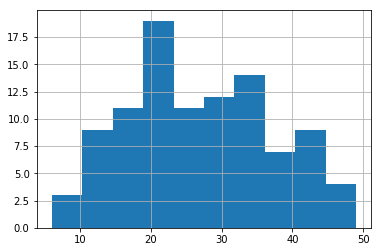

In [1001]:
test_df['travel_min_to_CBD'].hist()

# Task 2: Data Reshaping

The raw real estate price data is positively skewed. It needs to be transformed to be as close to a Gaussian distribution as most parametric statistical tools work with the assumption that datasets are normally distributed. The following normalization and transformation techniques real estate price attribute: 
- z-scale and minmax normalization, 
- log, power and sqrt transformation

It was found that applying a Log Transformation to the price data set transform the distribution to be closer to a Gaussian distribution. 

Furthermore, the transformed price data were used to build and test a linear regression model. The following predictors were used: bedrooms, bathrooms, parking_space and property type. Based on comparing the linear regression model's R^2 values, the min-max normalization returned the highest score of 0.07487. Using these predictors alone, the scores returned  seems to be too low so the suburbs were included as predictors. With this, the model performed better with the square root transformation returning a score of 0.51857. 

The summary of the computed R^2 values are as follows:

    0.05985536409468628	= lm.score for price_log
    0.0695808650150539	 = lm.score for price_sqrt
    0.0700424415183919	 = lm.score for price_pow
    0.07487496034315833	= lm.score for price_zcaled
    0.07487496034315844	= lm.score for price
    0.07487496034315844	= lm.score for price_minmax

It would seem that running a min-max normalization with the price dataset when grouped by suburb will improve the model. However, doing so and using it in the model only produced an R^2 value of 0.05455. 

Despite the explicit mention of using only the following predictors bedrooms, bathrooms, parking_space and property type in the model, I decided to add the suburb as a predictor to see its effect in the model. It turns out that adding the suburb as a predictor improves the performance of the model:

    0.3946200958452055	= lm.score for price_pow
    0.4959769594906026	= lm.score for price
    0.4959775052495343	= lm.score for price_zcaled
    0.4959781857575579	= lm.score for price_minmax
    0.5126400381155067	= lm.score for price_log
    0.5185763003946899	= lm.score for price_sqrt

#### Real Estate Price is Postively Skewed

In [923]:
merged_df_clean_100.describe()['price']

count    1.979000e+03
mean     9.461360e+06
std      6.076998e+06
min      9.840000e+05
25%      5.374500e+06
50%      7.705000e+06
75%      1.147400e+07
max      4.352000e+07
Name: price, dtype: float64

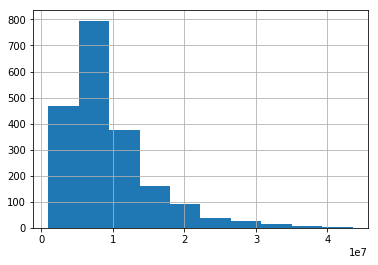

In [928]:
merged_df_clean_100.price.hist()

#### Applying a Log Transformation to Real Estate Price makes the distribution Gaussian

The log transformation on the real estate price makes it resemble a Gaussian distribution better with a mean of 15.89 and standard deviation of 0.5696. The log transformation was used because the price dataset fulfills log's assumptions that there are no zero or negative values and that the set is positvely skewed. 

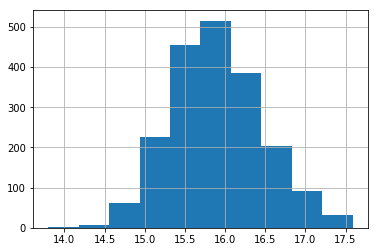

In [932]:
merged_df_clean_100["price"].apply(np.log).hist()

In [924]:
merged_df_clean_100["price"].apply(np.log).describe()

count    1979.000000
mean       15.894627
std         0.569658
min        13.799381
25%        15.497176
50%        15.857380
75%        16.255593
max        17.588731
Name: price, dtype: float64

In [ ]:
## Generating some graphs to see the distribution of the attributes

#plt.hist(math.log10(merged_df_clean_100['price']))
# realestate_json[realestate_json['property_id'].isnull()]
# merged_df_clean_100[merged_df_clean_100['bedrooms'] == 1]["price"].apply(np.log).hist(alpha = 0.3)
# merged_df_clean_100[merged_df_clean_100['bedrooms'] == 2]["price"].apply(np.log).hist(alpha = 0.3)
# merged_df_clean_100[merged_df_clean_100['bedrooms'] == 3]["price"].apply(np.log).hist(alpha = 0.3)
# plt.show()

## Generating a box plot per suburb
# merged_df_clean_100.boxplot(column = 'price', by = 'suburb', figsize=(30,10))
# plt.xticks(rotation=90)
# plt.show()

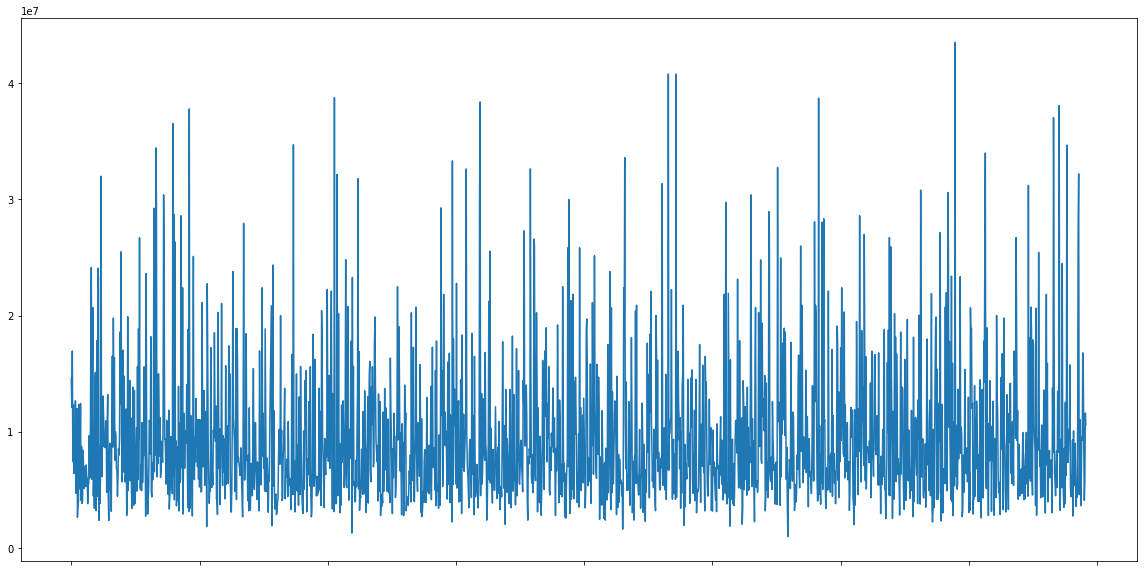

In [488]:
merged_df_clean_100.price.plot(figsize=(20,10))

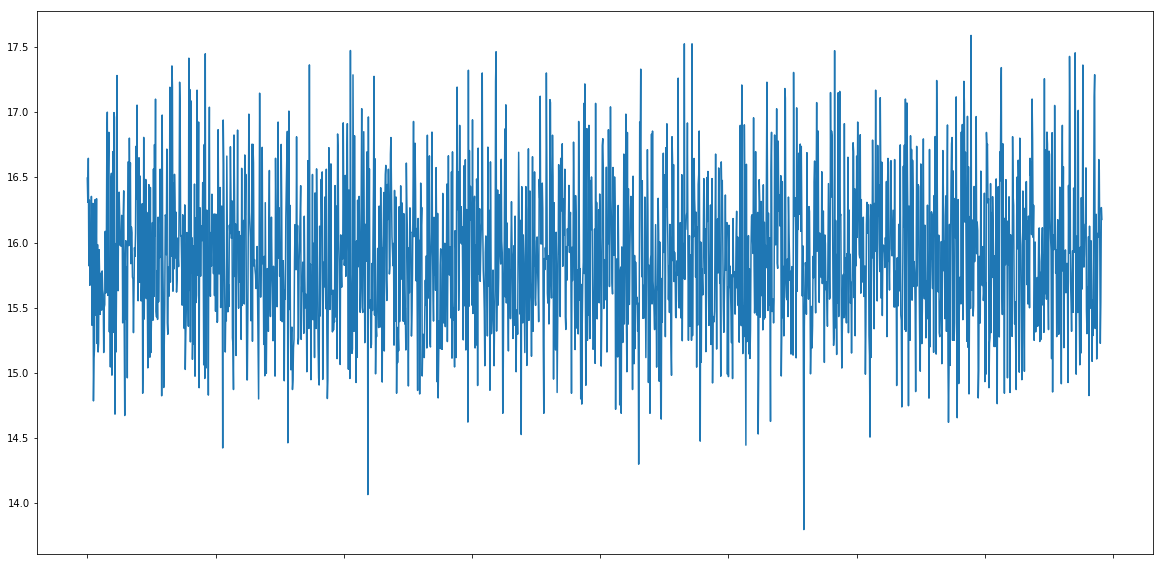

In [500]:
merged_df_clean_100["price"].apply(np.log).plot(figsize=(20,10))
# [merged_df_clean_100['bedrooms'] == 1]

#### Root Transformation

The root transformation can be used here as the data set is positively skewed and it is composed of simple counts only. The price data set also fulfils this transformation requirements that there should be no negative values. 

In [509]:
merged_df_clean_100_transformation = merged_df_clean_100.copy()

In [525]:
merged_df_clean_100_transformation['price_sqrt']  = \
merged_df_clean_100_transformation.apply(lambda row: round(math.sqrt(row['price']),3),axis=1)

In [528]:
merged_df_clean_100_transformation.head()

,addr_street,bathrooms,bedrooms,lat,lng,parking_space,price,property_id,property_type,year,Distance_to_sc,Shopping_center_id,Distance_to_supermarket,Supermarket_id,Distance_to_hospital,Hospital_id,Distance_to_train_station,Train_station_id,suburb,price_sqrt
n68483,32 Seymour Avenue,2.0,3.0,-37.857141,145.025811,2.0,14580000.0,68483.0,house,2013.0,2.405,SC_038,0.436,S_235,0.789,hospital_092,0.575,19945.0,ARMADALE,3818.377
n54361,3 Bell Street,2.0,3.0,-37.817227,145.039998,1.0,12100000.0,54361.0,house,2013.0,0.530,SC_083,0.502,S_208,0.833,hospital_086,0.566,19904.0,HAWTHORN,3478.505
n56088,1/34 Cumming Street,3.0,5.0,-37.852844,145.112739,2.0,16960000.0,56088.0,house,2016.0,3.304,SC_042,1.903,S_097,1.711,hospital_089,2.312,19840.0,BURWOOD,4118.252
n2948,173 Stephen Street,1.0,5.0,-37.820140,144.893952,2.0,7440000.0,2948.0,house,2013.0,4.103,SC_043,2.188,S_201,3.083,hospital_056,0.594,19996.0,YARRAVILLE,2727.636
n41974,27 Louise Street,2.0,3.0,-37.750397,145.075898,2.0,12315000.0,41974.0,house,2012.0,0.882,SC_017,1.176,S_100,1.355,hospital_066,1.199,19936.0,HEIDELBERG,3509.273


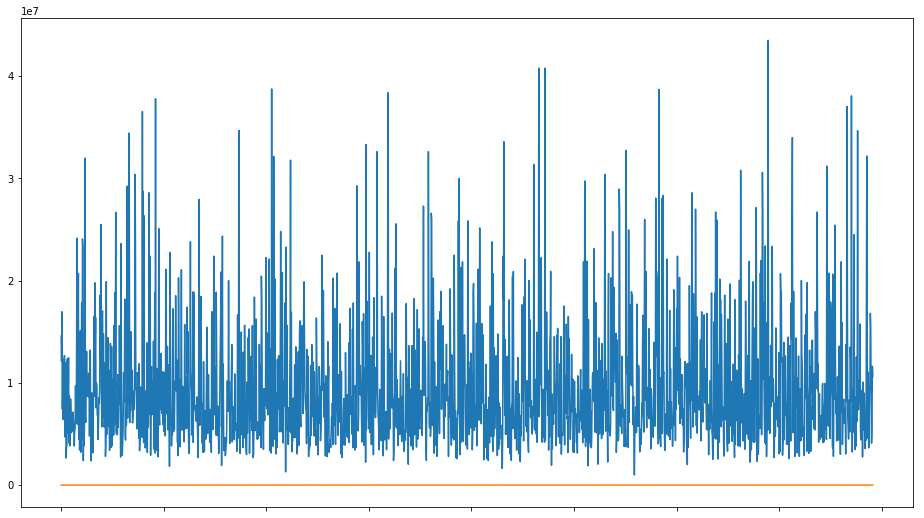

In [931]:
merged_df_clean_100_transformation.price.plot(figsize=(20,10))
merged_df_clean_100_transformation.price_sqrt.plot(figsize=(20,10))
plt.show()

#### Power

In [530]:
merged_df_clean_100_transformation['price_pow']  = \
merged_df_clean_100_transformation.apply(lambda row: round(math.pow(row['price'],2),3),axis=1)

In [531]:
merged_df_clean_100_transformation.head()

,addr_street,bathrooms,bedrooms,lat,lng,parking_space,price,property_id,property_type,year,...,Shopping_center_id,Distance_to_supermarket,Supermarket_id,Distance_to_hospital,Hospital_id,Distance_to_train_station,Train_station_id,suburb,price_sqrt,price_pow
n68483,32 Seymour Avenue,2.0,3.0,-37.857141,145.025811,2.0,14580000.0,68483.0,house,2013.0,...,SC_038,0.436,S_235,0.789,hospital_092,0.575,19945.0,ARMADALE,3818.377,2.125764e+14
n54361,3 Bell Street,2.0,3.0,-37.817227,145.039998,1.0,12100000.0,54361.0,house,2013.0,...,SC_083,0.502,S_208,0.833,hospital_086,0.566,19904.0,HAWTHORN,3478.505,1.464100e+14
n56088,1/34 Cumming Street,3.0,5.0,-37.852844,145.112739,2.0,16960000.0,56088.0,house,2016.0,...,SC_042,1.903,S_097,1.711,hospital_089,2.312,19840.0,BURWOOD,4118.252,2.876416e+14
n2948,173 Stephen Street,1.0,5.0,-37.820140,144.893952,2.0,7440000.0,2948.0,house,2013.0,...,SC_043,2.188,S_201,3.083,hospital_056,0.594,19996.0,YARRAVILLE,2727.636,5.535360e+13
n41974,27 Louise Street,2.0,3.0,-37.750397,145.075898,2.0,12315000.0,41974.0,house,2012.0,...,SC_017,1.176,S_100,1.355,hospital_066,1.199,19936.0,HEIDELBERG,3509.273,1.516592e+14


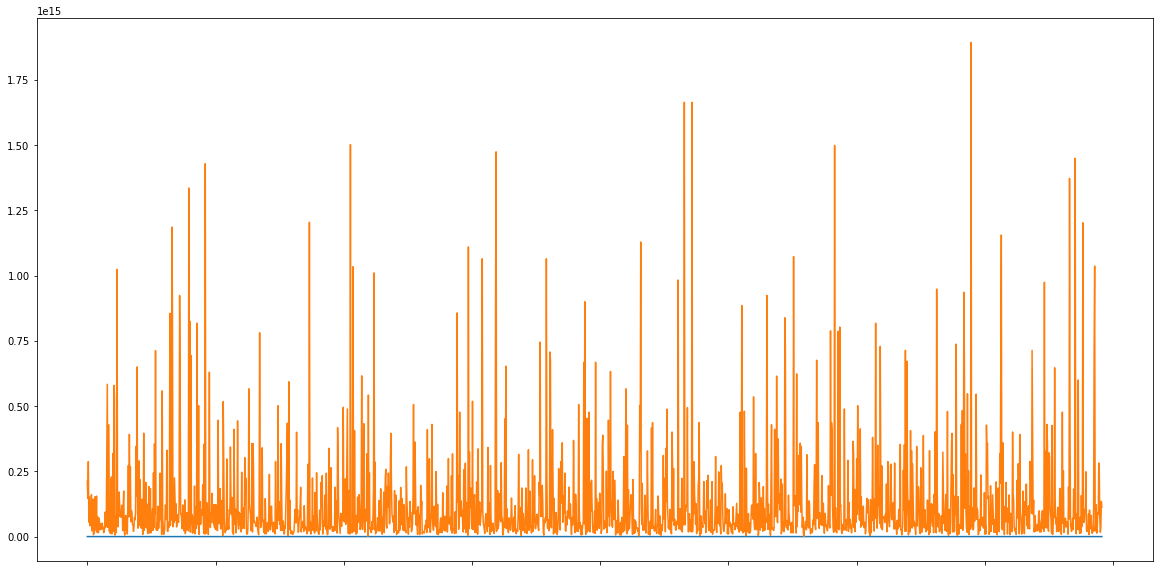

In [532]:
merged_df_clean_100_transformation.price.plot(figsize=(20,10))
merged_df_clean_100_transformation.price_pow.plot(figsize=(20,10))
plt.show()

#### Log

In [533]:
merged_df_clean_100_transformation['price_log']  = \
merged_df_clean_100_transformation.apply(lambda row: round(math.log(row['price']),3),axis=1)

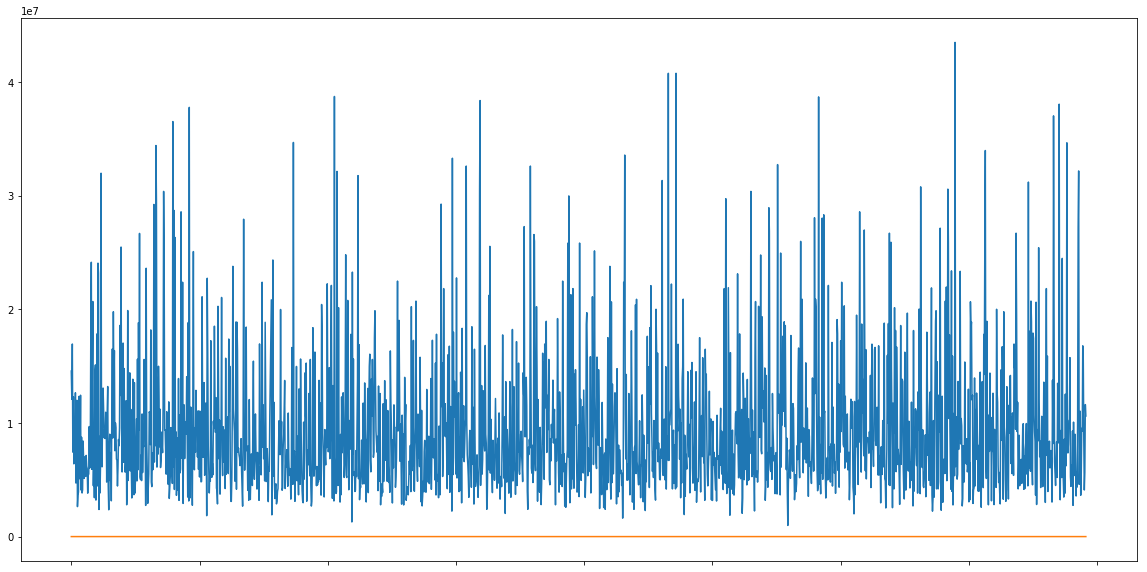

In [534]:
merged_df_clean_100_transformation.price.plot(figsize=(20,10))
merged_df_clean_100_transformation.price_log.plot(figsize=(20,10))
plt.show()

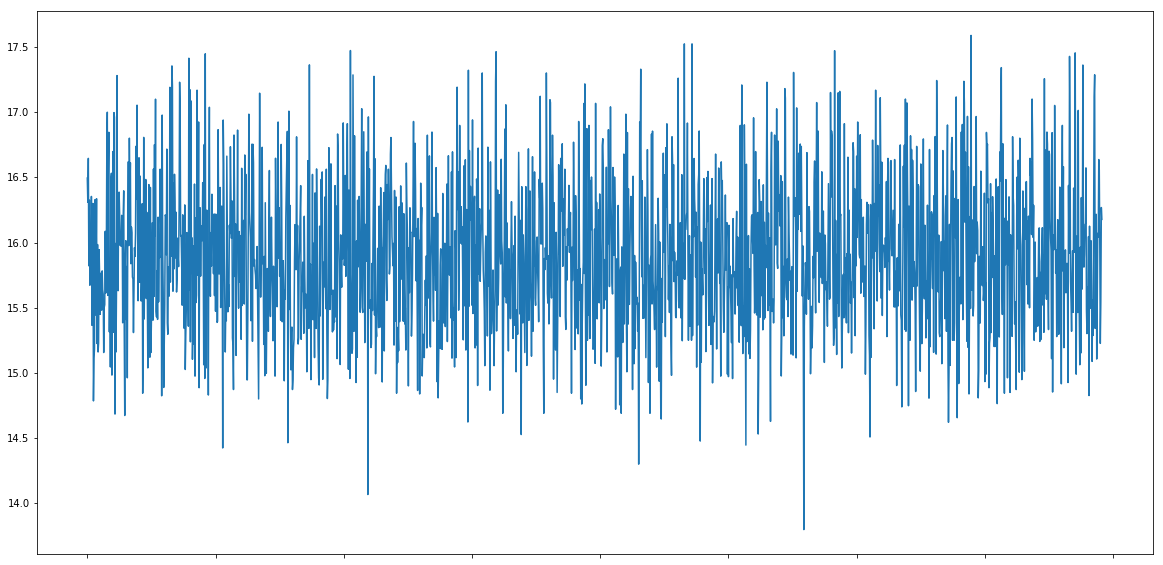

In [535]:
merged_df_clean_100_transformation.price_log.plot(figsize=(20,10))

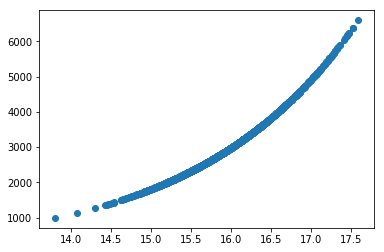

In [536]:
plt.scatter(merged_df_clean_100_transformation.price_log,merged_df_clean_100_transformation.price_sqrt)

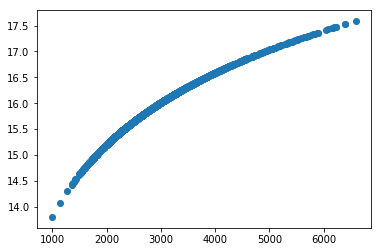

In [537]:
plt.scatter(merged_df_clean_100_transformation.price_sqrt,merged_df_clean_100_transformation.price_log)

#### Z-Score Normalization

The aim of this normalization is transforming the data such that the mean is 0 and the standard deviation is 1. 

In [547]:
std_scale = preprocessing.StandardScaler().fit(merged_df_clean_100_transformation[['price']])
df_std = std_scale.transform(merged_df_clean_100_transformation[['price']]) # an array not a df
df_std[0:5]

array([[ 0.84251044],
       [ 0.43431105],
       [ 1.23425017],
       [-0.33270875],
       [ 0.46969931]])

In [548]:
merged_df_clean_100_transformation['price_zcaled'] = df_std[:,0]

In [549]:
merged_df_clean_100_transformation.head()


,addr_street,bathrooms,bedrooms,lat,lng,parking_space,price,property_id,property_type,year,...,Supermarket_id,Distance_to_hospital,Hospital_id,Distance_to_train_station,Train_station_id,suburb,price_sqrt,price_pow,price_log,price_zcaled
n68483,32 Seymour Avenue,2.0,3.0,-37.857141,145.025811,2.0,14580000.0,68483.0,house,2013.0,...,S_235,0.789,hospital_092,0.575,19945.0,ARMADALE,3818.377,2.125764e+14,16.495,0.842510
n54361,3 Bell Street,2.0,3.0,-37.817227,145.039998,1.0,12100000.0,54361.0,house,2013.0,...,S_208,0.833,hospital_086,0.566,19904.0,HAWTHORN,3478.505,1.464100e+14,16.309,0.434311
n56088,1/34 Cumming Street,3.0,5.0,-37.852844,145.112739,2.0,16960000.0,56088.0,house,2016.0,...,S_097,1.711,hospital_089,2.312,19840.0,BURWOOD,4118.252,2.876416e+14,16.646,1.234250
n2948,173 Stephen Street,1.0,5.0,-37.820140,144.893952,2.0,7440000.0,2948.0,house,2013.0,...,S_201,3.083,hospital_056,0.594,19996.0,YARRAVILLE,2727.636,5.535360e+13,15.822,-0.332709
n41974,27 Louise Street,2.0,3.0,-37.750397,145.075898,2.0,12315000.0,41974.0,house,2012.0,...,S_100,1.355,hospital_066,1.199,19936.0,HEIDELBERG,3509.273,1.516592e+14,16.326,0.469699


In [550]:
merged_df_clean_100_transformation.price_zcaled.describe()

count    1.979000e+03
mean    -3.632488e-17
std      1.000253e+00
min     -1.395344e+00
25%     -6.726829e-01
50%     -2.890907e-01
75%      3.312736e-01
max      5.605934e+00
Name: price_zcaled, dtype: float64

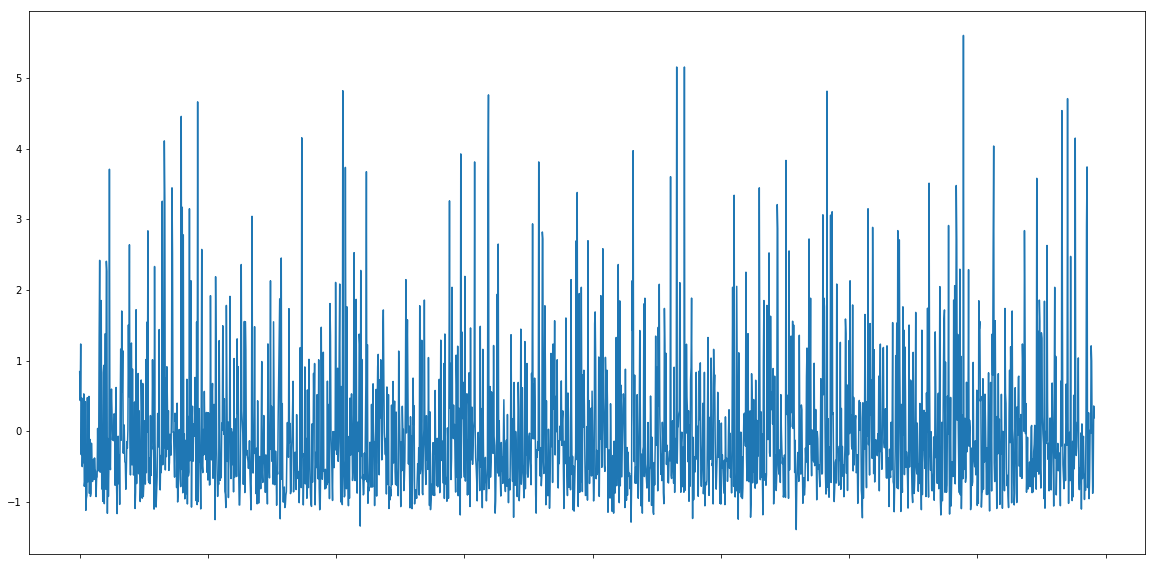

In [553]:
merged_df_clean_100_transformation.price_zcaled.plot(figsize=(20,10))

#### MinMax Normalization

This transformation scales the dataset relative to a range, which in this case is the minimum and maximum values. 

In [558]:
minmax_scale = preprocessing.MinMaxScaler().fit(merged_df_clean_100_transformation[['price']])
df_minmax = minmax_scale.transform(merged_df_clean_100_transformation[['price']])
df_minmax[0:5]

array([[0.31963513],
       [0.26133158],
       [0.37558774],
       [0.15177732],
       [0.26638612]])

In [559]:
merged_df_clean_100_transformation['price_minmax'] = df_minmax[:,0]

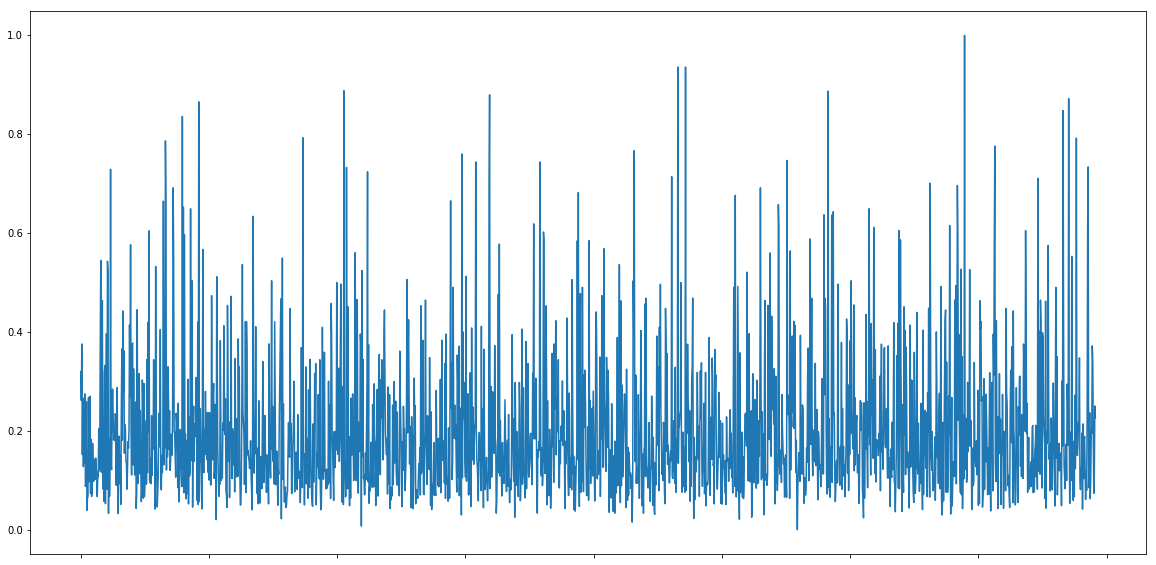

In [560]:
merged_df_clean_100_transformation.price_minmax.plot(figsize=(20,10))

In [930]:
## Checking how many houses there are per suburb
merged_df_clean_100_transformation.suburb.value_counts()

RESERVOIR           62
CRAIGIEBURN         61
BUNDOORA            46
COBURG              40
GREENSBOROUGH       35
PRESTON             35
CHELTENHAM          34
CROYDON             33
BENTLEIGH           33
MOOROOLBARK         32
YARRAVILLE          31
BORONIA             30
LILYDALE            30
EPPING              29
NORTHCOTE           29
RICHMOND            28
MULGRAVE            28
ELTHAM              28
BRIGHTON            25
BLACKBURN           25
DONCASTER           24
KEYSBOROUGH         24
KEW                 23
BRUNSWICK           23
DANDENONG           22
MITCHAM             22
THORNBURY           22
GLENROY             21
BULLEEN             21
ESSENDON            21
                    ..
BURNSIDE             3
ABERFELDIE           3
LAVERTON             3
SEAHOLME             3
MELBOURNE            3
ARDEER               3
MARIBYRNONG          3
BELLFIELD            3
HUNTINGDALE          3
PARKVILLE            2
EUMEMMERRING         2
KEILOR               2
JACANA     

In [605]:
# There are 163 suburbs
len(merged_df_clean_100_transformation.suburb.value_counts())

163

In [630]:
# Checking the summary of the price_zscaled per suburb
merged_df_clean_100_transformation[['price_zcaled','suburb']].groupby('suburb').describe()


price_zcaled                                          \
                        count      mean       std       min       25%   
suburb                                                                  
ABBOTSFORD               11.0  0.612868  1.745761 -0.405131 -0.179634   
ABERFELDIE                3.0  0.689710  0.679737 -0.072646  0.418263   
ALBANVALE                 5.0 -0.870446  0.276758 -1.142524 -1.104666   
ALBION                    9.0 -0.669290  0.216625 -1.093803 -0.816623   
ALPHINGTON                4.0  1.295562  0.987416  0.379994  0.600965   
ALTONA                    5.0  0.592620  1.757071 -0.416653 -0.309830   
ARDEER                    3.0 -0.818323  0.159347 -0.986980 -0.892337   
ARMADALE                  8.0  1.614365  1.339786  0.063146  0.740049   
ASHBURTON                17.0  0.781832  0.945596 -0.500597  0.090304   
ASHWOOD                  13.0  0.873746  1.194614 -0.859418  0.207991   
ASPENDALE                 5.0 -0.026263  0.396172 -0.454510 -0.316249   
ATTWOOD                   5.0 -0.639385  0.261767 -1.055288 -0.669802   
BALACLAVA                 1.0  0.985709       NaN  0.985709  0.985709   
BALWYN                   16.0  1.112552  1.082576 -0.293206  0.374233   
BAYSWATER                12.0 -0.351596  0.399077 -0.846250 -0.678115   
BEAUMARIS                18.0  1.098915  0.944868 -0.813331  0.615367   
BELLFIELD                 3.0 -0.584075  0.289494 -0.872174 -0.729510   
BENTLEIGH                33.0  0.266891  0.811040 -0.954225 -0.240535   
BLACKBURN                25.0  0.327857  0.735917 -0.747492 -0.248765   
BONBEACH                  5.0 -0.511131  0.405084 -0.846250 -0.816623   
BORONIA                  30.0 -0.508800  0.357443 -1.061871 -0.724037   
BRAYBROOK                 5.0 -0.383997  0.437797 -0.806747 -0.561498   
BRIGHTON                 25.0  1.571528  1.238347 -0.253702  0.760212   
BROADMEADOWS             15.0 -0.848477  0.227447 -1.228114 -0.969697   
BROOKLYN                  4.0 -0.520843  0.455091 -0.934474 -0.901637   
BRUNSWICK                23.0  0.201786  0.742132 -0.877359 -0.333120   
BULLEEN                  21.0 -0.020007  0.554161 -0.875877 -0.520349   
BUNDOORA                 46.0 -0.367850  0.530011 -1.056933 -0.707989   
BURNLEY                   1.0 -0.125153       NaN -0.125153 -0.125153   
BURNSIDE                  3.0 -0.852505  0.269955 -1.162275 -0.945008   
...                       ...       ...       ...       ...       ...   
ROWVILLE                  5.0  0.029832  0.470334 -0.633920 -0.231976   
SANDRINGHAM              11.0  0.659105  1.074253 -0.769713 -0.066392   
SEABROOK                 10.0 -0.792740  0.203514 -1.238154 -0.885012   
SEAHOLME                  3.0 -0.238669  0.869684 -1.138573 -0.656635   
SEDDON                   14.0  0.425564  0.788104 -0.908467 -0.012445   
SOUTH KINGSVILLE          1.0 -0.446280       NaN -0.446280 -0.446280   
SPRINGVALE               18.0 -0.146431  1.123019 -1.056933 -0.733501   
ST ALBANS                 2.0 -1.063517  0.158287 -1.175443 -1.119480   
ST HELENA                 1.0 -0.102274       NaN -0.102274 -0.102274   
STRATHMORE                7.0  0.365698  0.657186 -0.525945  0.080099   
SUNSHINE                 17.0 -0.464938  0.482152 -1.122772 -0.688237   
SYDENHAM                 16.0 -0.753294  0.226842 -1.092157 -0.895629   
TEMPLESTOWE               4.0  1.305027  2.379264 -0.398547  0.065615   
THOMASTOWN                4.0 -0.742966  0.137204 -0.913241 -0.823001   
THORNBURY                22.0  0.117575  0.518081 -0.691858 -0.230741   
TOORAK                    5.0  1.726065  2.273151 -1.188611  1.158536   
TRAVANCORE                2.0 -0.102685  0.196113 -0.241358 -0.172021   
TRUGANINA                15.0 -0.633975  0.262328 -1.024014 -0.844604   
TULLAMARINE               1.0 -0.327442       NaN -0.327442 -0.327442   
VERMONT                  11.0  0.110176  0.680669 -0.740908 -0.377973   
VIEWBANK                  1.0 -1.149931       NaN -1.149931 -1.149931   
WA

In [631]:
merged_df_clean_100_transformation[['price_log','suburb']].groupby('suburb').describe()



price_log                                                  \
                     count       mean       std     min       25%      50%   
suburb                                                                       
ABBOTSFORD            11.0  16.227000  0.528383  15.761  15.93550  16.1330   
ABERFELDIE             3.0  16.394667  0.334503  16.015  16.26900  16.5230   
ALBANVALE              5.0  15.179400  0.402601  14.740  14.82700  15.2140   
ALBION                 9.0  15.469444  0.281519  14.851  15.32000  15.5560   
ALPHINGTON             4.0  16.624250  0.339905  16.281  16.38750  16.5890   
ALTONA                 5.0  16.194200  0.627541  15.751  15.84100  15.9250   
ARDEER                 3.0  15.301000  0.224261  15.058  15.20150  15.3450   
ARMADALE               8.0  16.698875  0.413384  16.102  16.44825  16.6595   
ASHBURTON             17.0  16.396412  0.393610  15.675  16.11900  16.3540   
ASHWOOD               13.0  16.396077  0.505855  15.260  16.18800  16.3530   
ASPENDALE              5.0  16.019000  0.258494  15.718  15.83600  15.9800   
ATTWOOD                5.0  15.494000  0.335166  14.931  15.50000  15.5730   
BALACLAVA              1.0  16.553000       NaN  16.553  16.55300  16.5530   
BALWYN                16.0  16.532063  0.381754  15.854  16.27750  16.5365   
BAYSWATER             12.0  15.759583  0.317269  15.279  15.49100  15.7735   
BEAUMARIS             18.0  16.522111  0.431271  15.324  16.39275  16.6455   
BELLFIELD              3.0  15.562000  0.306959  15.242  15.41600  15.5900   
BENTLEIGH             33.0  16.128273  0.443811  15.114  15.89500  16.1670   
BLACKBURN             25.0  16.179600  0.398566  15.409  15.88900  16.2130   
BONBEACH               5.0  15.609800  0.362849  15.279  15.32000  15.4940   
BORONIA               30.0  15.607900  0.357108  14.917  15.43750  15.6580   
BRAYBROOK              5.0  15.730400  0.342058  15.333  15.61600  15.6390   
BRIGHTON              25.0  16.684680  0.402217  15.885  16.46000  16.6650   
BROADMEADOWS          15.0  15.229933  0.314157  14.509  15.08550  15.2650   
BROOKLYN               4.0  15.577500  0.460991  15.146  15.19700  15.5745   
BRUNSWICK             23.0  16.101783  0.419251  15.234  15.82200  16.2090   
BULLEEN               21.0  15.981095  0.392070  15.236  15.65600  16.0530   
BUNDOORA              46.0  15.713804  0.391940  14.927  15.45650  15.7055   
BURNLEY                1.0  15.979000       NaN  15.979  15.97900  15.9790   
BURNSIDE               3.0  15.209000  0.449964  14.691  15.06200  15.4330   
...                    ...        ...       ...     ...       ...      ...   
ROWVILLE               5.0  16.041400  0.328696  15.540  15.90100  16.1870   
SANDRINGHAM           11.0  16.304000  0.507731  15.381  16.01050  16.3680   
SEABROOK              10.0  15.308100  0.336539  14.478  15.22225  15.4165   
SEAHOLME               3.0  15.693333  0.847282  14.749  15.34650  15.9440   
SEDDON                14.0  16.222643  0.439687  15.187  16.05250  16.2775   
SOUTH KINGSVILLE       1.0  15.725000       NaN  15.725  15.72500  15.7250   
SPRINGVALE            18.0  15.782389  0.565438  14.927  15.42575  15.6915   
ST ALBANS              2.0  14.887500  0.325976  14.657  14.77225  14.8875   
ST HELENA              1.0  15.995000       NaN  15.995  15.99500  15.9950   
STRATHMORE             7.0  16.222857  0.347517  15.651  16.11250  16.1780   
SUNSHINE              17.0  15.619176  0.441193  14.786  15.47900  15.6220   
SYDENHAM              16.0  15.364562  0.282580  14.854  15.20700  15.3025   
TEMPLESTOWE            4.0  16.453000  0.726484  15.767  16.08800  16.2860   
THOMASTOWN             4.0  15.403250  0.174550  15.180  15.30825  15.4355   
THORNBURY             22.0  16.093409  0.292372  15.475  15.90250  16.0665   
TOORAK                 5.0  16.478800  1.094484  14.622  16.61900  16.7580   
TRAVANCORE             2.0  15.990000  0.135765  15.894  15.94200  15.9900   
TRUGANINA             15.0  15.503200  

### Linear Regression

The following section evaluates the performance of the different price transformations when used in a linear model with the following variables as predictors: 'bedrooms', 'bathrooms',  'parking_space'.



In [731]:
# define the data/predictors as the pre-set feature names  
df = merged_df_clean_100_transformation[['bedrooms', 'bathrooms',  'parking_space']]

# Put the target (housing value -- MEDV) in another DataFrame
target = merged_df_clean_100_transformation[['price']]

In [622]:
X = df
y = target['price']

#### Using SKLearn to build the Model

In [593]:
lm = linear_model.LinearRegression()
# From: http://scikit-learn.org/stable/modules/generated/sklearn.linear_model.LinearRegression.html

0.07487496034315844

In [590]:
model = lm.fit(X,y)
lm.score(X,y)
predictions = lm.predict(X)
# print(predictions)[0:5]


[ 9958589.90836993  9955497.06348749 13828420.18767054 10360089.66953927
  9958589.90836993]


#### Comparing the Linear Model Performance of the Price Transformations 

In [623]:
price_transformations = ['price','price_sqrt','price_pow','price_log','price_zcaled','price_minmax']

In [670]:
for price_transformation in price_transformations:
    
    target = merged_df_clean_100_transformation[[price_transformation]]
    y = target[price_transformation]
    model = lm.fit(X,y)
    print('lm.score for ' + price_transformation + ': \t' + str(lm.score(X,y)))

lm.score for price: 	0.07487496034315844
lm.score for price_sqrt: 	0.0695808650150539
lm.score for price_pow: 	0.0700424415183919
lm.score for price_log: 	0.05985536409468628
lm.score for price_zcaled: 	0.07487496034315833
lm.score for price_minmax: 	0.07487496034315844


#### Adding Suburbs as a Predictor in the Linear Model

Due to the low R^2 values of the previous models, I tried including the suburb as a predictor in the linear model. This improved the performance of the model. Since subrb is a categorial variable, they are converted into dummy variables (ie. also referred to as one-hot encoding) and these are fed into the linear model.


In [714]:
dummies = pd.get_dummies(merged_df_clean_100_transformation.suburb)
# dummies.index
# dummies.describe()
# dummies.head()

Index([u'n68483', u'n54361', u'n56088', u'n2948', u'n41974', u'n45183',
       u'n70903', u'n10948', u'n69429', u'n64105',
       ...
       u'n22073', u'n41096', u'n71084', u'n20711', u'n87081', u'n76704',
       u'n12375', u'n70587', u'n64500', u'n51798'],
      dtype='object', length=1979)

In [745]:
merged_df_clean_100_with_dummies = \
pd.concat([merged_df_clean_100_transformation[['bedrooms', 'bathrooms',  'parking_space']],\
           dummies],axis=1)

In [746]:
merged_df_clean_100_with_dummies.head()

,bedrooms,bathrooms,parking_space,ABBOTSFORD,ABERFELDIE,ALBANVALE,ALBION,ALPHINGTON,ALTONA,ARDEER,...,VIEWBANK,WANTIRNA,WARRANWOOD,WATSONIA,WERRIBEE,WESTMEADOWS,WILLIAMS LANDING,WINDSOR,YALLAMBIE,YARRAVILLE
n68483,3.0,2.0,2.0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
n54361,3.0,2.0,1.0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
n56088,5.0,3.0,2.0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
n2948,5.0,1.0,2.0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,1
n41974,3.0,2.0,2.0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0


In [754]:
prices = merged_df_clean_100_transformation[['price','price_sqrt','price_pow','price_log','price_zcaled','price_minmax']]

#### Adding the Suburbs as Predictors Significantly Improves the Model

In [759]:
df = merged_df_clean_100_with_dummies
X = df
for price_transformation in price_transformations:
    
    target = prices[[price_transformation]]
    y = target[price_transformation]
    model = lm.fit(X,y)
    print('lm.score for ' + price_transformation + ': \t' + str(lm.score(X,y)))

lm.score for price: 	0.49597695949060266
lm.score for price_sqrt: 	0.5185763003946899
lm.score for price_pow: 	0.3946200958452055
lm.score for price_log: 	0.5126400381155067
lm.score for price_zcaled: 	0.49597750524953443
lm.score for price_minmax: 	0.4959781857575579


#### Adding the proximity of the Establishments with the Suburbs Does Not Improve the Model

I also tried incorporating the distance from the nearest establishments. Howerver, they have no significant impact in the performance of the model. 

In [767]:
merged_df_clean_100_with_dummies = \
pd.concat([merged_df_clean_100_transformation[['bedrooms', 'bathrooms',  'parking_space',\
                                               'Distance_to_sc','Distance_to_supermarket','Distance_to_hospital','Distance_to_train_station']],\
           dummies],axis=1)

In [765]:
df = merged_df_clean_100_with_dummies
X = df
for price_transformation in price_transformations:
    
    target = prices[[price_transformation]]
    y = target[price_transformation]
    model = lm.fit(X,y)
    print('lm.score for ' + price_transformation + ': \t' + str(lm.score(X,y)))

lm.score for price: 	0.49632222736884607
lm.score for price_sqrt: 	0.5186456739823644
lm.score for price_pow: 	0.3959520240805603
lm.score for price_log: 	0.5126138825052442
lm.score for price_zcaled: 	0.49632342928941986
lm.score for price_minmax: 	0.49632220540336225


In [772]:
merged_df_clean_100_with_dummies = \
pd.concat([merged_df_clean_100_transformation[['bedrooms', 'bathrooms',  'parking_space']],\
           dummies],axis=1)

df = merged_df_clean_100_with_dummies
X = df
for price_transformation in price_transformations:
    
    target = prices[[price_transformation]]
    y = target[price_transformation]
    model = lm.fit(X,y)
    print('lm.score for ' + price_transformation + ': \t' + str(lm.score(X,y)))

lm.score for price: 	0.49597695949060266
lm.score for price_sqrt: 	0.5185763003946899
lm.score for price_pow: 	0.3946200958452055
lm.score for price_log: 	0.5126400381155067
lm.score for price_zcaled: 	0.49597750524953443
lm.score for price_minmax: 	0.4959781857575579


In [760]:
merged_df_clean_100_transformation.info()

<class 'pandas.core.frame.DataFrame'>
Index: 1979 entries, n68483 to n51798
Data columns (total 24 columns):
addr_street                  1979 non-null object
bathrooms                    1979 non-null float64
bedrooms                     1979 non-null float64
lat                          1979 non-null float64
lng                          1979 non-null float64
parking_space                1979 non-null float64
price                        1979 non-null float64
property_id                  1979 non-null float64
property_type                1979 non-null object
year                         1979 non-null float64
Distance_to_sc               1979 non-null float64
Shopping_center_id           1979 non-null object
Distance_to_supermarket      1979 non-null float64
Supermarket_id               1979 non-null object
Distance_to_hospital         1979 non-null float64
Hospital_id                  1979 non-null object
Distance_to_train_station    1979 non-null float64
Train_station_id             

#### MinMax Transformation per Suburb

In the effort to improve the model, I tried doing a min-max transformation to the price grouped per suburb. The real estate prices per suburb were scaled based on the minium and maximum prices in that suburb. However, there was no significant improvement in the model. The model's R^2 value is 0.05454. 

In [904]:
merged_df_transformation_per_suburb = \
merged_df_transformation_per_suburb[~(merged_df_transformation_per_suburb.index.duplicated())]


In [905]:
merged_df_transformation_per_suburb.shape

(1964, 20)

In [906]:
merged_df_transformation_per_suburb['price_minmax_x_suburb'] = \
(merged_df_transformation_per_suburb.groupby('suburb')['price'].\
apply(lambda x: (x-x.min())/(x.max()-x.min())))



In [912]:
merged_df_transf_per_suburb_nonan = merged_df_transformation_per_suburb[~(merged_df_transformation_per_suburb['price_minmax_x_suburb'].isnull())]
merged_df_transf_per_suburb_nonan.shape

(1949, 20)

In [908]:
merged_df_transformation_per_suburb_preds = merged_df_transf_per_suburb_nonan[['bedrooms', 'bathrooms',  'parking_space']]

In [909]:
X = merged_df_transformation_per_suburb_preds

In [915]:
target = merged_df_transf_per_suburb_nonan[['price_minmax_x_suburb']]
y = target
model = lm.fit(X,y)
print('lm.score for price_minmax_x_suburb: \t' + str(lm.score(X,y)))

lm.score for price_minmax_x_suburb: 	0.05454908130070323


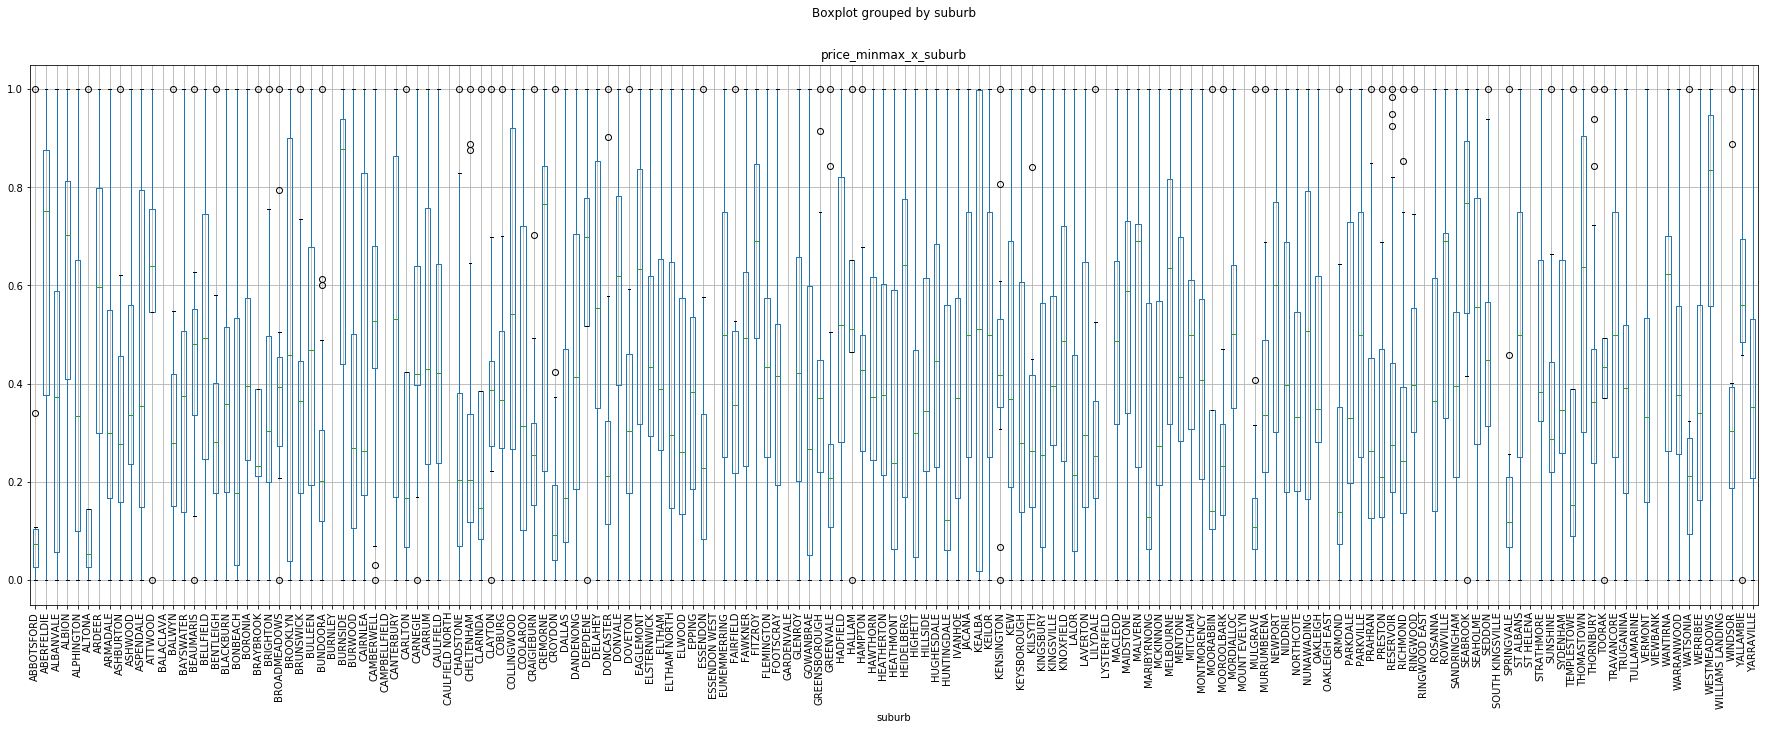

In [921]:

merged_df_transformation_per_suburb.boxplot(column = 'price_minmax_x_suburb', by = 'suburb',figsize=(30,10) )
plt.xticks(rotation=90)
plt.show()

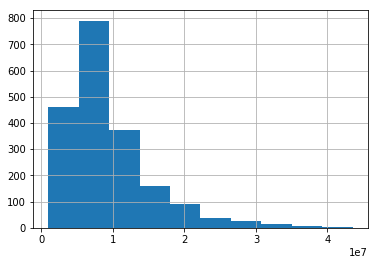

In [898]:
merged_df_transformation_per_suburb['price'].hist()

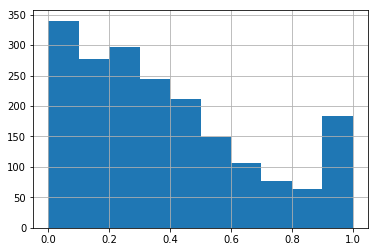

In [899]:
merged_df_transformation_per_suburb['price_minmax_x_suburb'].hist()

# Exportation

#### Preparing the dataframe for exportation

In [966]:
merged_df_transformation_per_suburb.shape

(1964, 20)

In [965]:
merged_df_transformation_per_suburb.head()

,addr_street,bathrooms,bedrooms,lat,lng,parking_space,price,property_id,property_type,year,Distance_to_sc,Shopping_center_id,Distance_to_supermarket,Supermarket_id,Distance_to_hospital,Hospital_id,Distance_to_train_station,Train_station_id,suburb,price_minmax_x_suburb
n68483,32 Seymour Avenue,2.0,3.0,-37.857141,145.025811,2.0,14580000.0,68483.0,house,2013.0,2.405,SC_038,0.436,S_235,0.789,hospital_092,0.575,19945.0,ARMADALE,0.192519
n54361,3 Bell Street,2.0,3.0,-37.817227,145.039998,1.0,12100000.0,54361.0,house,2013.0,0.530,SC_083,0.502,S_208,0.833,hospital_086,0.566,19904.0,HAWTHORN,0.250183
n56088,1/34 Cumming Street,3.0,5.0,-37.852844,145.112739,2.0,16960000.0,56088.0,house,2016.0,3.304,SC_042,1.903,S_097,1.711,hospital_089,2.312,19840.0,BURWOOD,0.523828
n2948,173 Stephen Street,1.0,5.0,-37.820140,144.893952,2.0,7440000.0,2948.0,house,2013.0,4.103,SC_043,2.188,S_201,3.083,hospital_056,0.594,19996.0,YARRAVILLE,0.286897
n41974,27 Louise Street,2.0,3.0,-37.750397,145.075898,2.0,12315000.0,41974.0,house,2012.0,0.882,SC_017,1.176,S_100,1.355,hospital_066,1.199,19936.0,HEIDELBERG,0.627548


In [1037]:

merged_df_transformation_per_suburb.loc['n11205']

addr_street                  19 Rowe Street
bathrooms                                 2
bedrooms                                  4
lat                                -37.7819
lng                                 144.887
parking_space                             2
price                              7.11e+06
property_id                           11205
property_type                         house
year                                   2011
Distance_to_sc                        0.957
Shopping_center_id                   SC_085
Distance_to_supermarket               0.982
Supermarket_id                        S_049
Distance_to_hospital                  1.159
Hospital_id                    hospital_003
Distance_to_train_station             1.868
Train_station_id                      20027
suburb                          MARIBYRNONG
price_minmax_x_suburb              0.128169
Name: n11205, dtype: object

In [1039]:
merged_df_for_exportation = merged_df_transformation_per_suburb.copy()

# For some reason there's something wrong with this station ID
# I'm just removing it from the dataframe since thy are only 2 lines
#merged_df_transformation_per_suburb[(merged_df_transformation_per_suburb.Train_station_id == 20027)]

merged_df_for_exportation = \
merged_df_for_exportation[~(merged_df_for_exportation.Train_station_id == 20027)]


In [1055]:
## Use the formula to get Transfer Flag and Travel Min to CBD
merged_df_for_exportation[['transfer_flag','travel_min_to_CBD']] = \
    merged_df_for_exportation.apply\
    (lambda row: pd.Series( \
                           [get_nearest_travel_min_to_CBD(row)[0],\
                            get_nearest_travel_min_to_CBD(row)[1]]\
                            ),axis=1)

In [1056]:
# Cleaning up columns
merged_df_for_exportation.columns = [x.lower() for x in merged_df_for_exportation.columns]
merged_df_for_exportation = merged_df_for_exportation.rename(columns={'travel_min_to_cbd': 'travel_min_to_CBD'})




In [1058]:
# Delete unnecessary column
del merged_df_for_exportation['price_minmax_x_suburb']

In [1094]:
# Cleaning up columns
merged_df_for_exportation['year'] = merged_df_for_exportation['year'].astype(int)
merged_df_for_exportation['property_id'] = merged_df_for_exportation['property_id'].astype(int)
merged_df_for_exportation['bathrooms'] = merged_df_for_exportation['bathrooms'].astype(int)
merged_df_for_exportation['bedrooms'] = merged_df_for_exportation['bedrooms'].astype(int)
merged_df_for_exportation['parking_space'] = merged_df_for_exportation['parking_space'].astype(int)


merged_df_for_exportation.head()

,addr_street,bathrooms,bedrooms,lat,lng,parking_space,price,property_id,property_type,year,...,shopping_center_id,distance_to_supermarket,supermarket_id,distance_to_hospital,hospital_id,distance_to_train_station,train_station_id,suburb,transfer_flag,travel_min_to_CBD
n68483,32 Seymour Avenue,2,3,-37.857141,145.025811,2,14580000.0,68483,house,2013,...,SC_038,0.436,S_235,0.789,hospital_092,0.575,19945.0,ARMADALE,0,0
n54361,3 Bell Street,2,3,-37.817227,145.039998,1,12100000.0,54361,house,2013,...,SC_083,0.502,S_208,0.833,hospital_086,0.566,19904.0,HAWTHORN,0,0
n56088,1/34 Cumming Street,3,5,-37.852844,145.112739,2,16960000.0,56088,house,2016,...,SC_042,1.903,S_097,1.711,hospital_089,2.312,19840.0,BURWOOD,0,0
n2948,173 Stephen Street,1,5,-37.820140,144.893952,2,7440000.0,2948,house,2013,...,SC_043,2.188,S_201,3.083,hospital_056,0.594,19996.0,YARRAVILLE,0,0
n41974,27 Louise Street,2,3,-37.750397,145.075898,2,12315000.0,41974,house,2012,...,SC_017,1.176,S_100,1.355,hospital_066,1.199,19936.0,HEIDELBERG,0,0


In [1095]:
merged_df_for_exportation.to_csv("29999804_solution.csv", sep =',',index=True)


# Conclusion

Through parsing data from various datasets and data formats, a unified list of property listing with the proximity to major establisments was formulated. Several normalization and transformation procdures were applied to the real estate pricing data to prepare it for further statistical processing. It was positively skewed and needed to be transformed as a Gaussian distribution. The following normalization and transformation techniques real estate price attribute: z-scale and minmax normalization, and log, power and square root transformation

Applying a Log Transformation removed the skewness of the distribution and transformed it closer to a Gaussian distribution. The effect on the linear model of these transformations on the price was also studied. Using bedrooms, bathrooms, parking_space and property type as predictors, the linear regression model's R^2 values, the min-max normalization returned the highest score of 0.07487. Using these predictors alone, the scores returned  seems to be too low so the suburbs were included as predictors. With this, the model performed better with the square root transformation returning a score of 0.51857. 